# Unbalanced Decision tree - dataset: echo_popul.csv
## Task: Song popularity prediction

In [44]:
%matplotlib inline
 
import pandas as pd
import numpy as np
from utility_functions import report

# sklearn modules 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
from statistics import mean
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [45]:
echo_popul = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_popul.csv')
echo_popul.set_index('track_id', inplace=True)
echo_popul.head()

,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,listens,duration,bit_rate,comments,interest,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,popularity
track_id,,,,,,,,,,,,,,,,,,
2,0.388990,0.386740,0.406370,0.000000,1293,168,256000,0,4656,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,not popular
3,0.388990,0.386740,0.406370,0.000000,514,237,256000,0,1470,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,not popular
5,0.388990,0.386740,0.406370,0.000000,1151,206,256000,0,1933,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,not popular
10,0.557339,0.614272,0.798387,0.005158,50135,161,192000,0,54881,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,popular
134,0.388990,0.386740,0.406370,0.000000,943,207,256000,0,1126,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,not popular


In [46]:
# encoding labels: 0 --> not popular,  1 --> popular
le = preprocessing.LabelEncoder()
echo_popul['popularity'] = le.fit_transform(echo_popul['popularity'])

In [47]:
echo_popul['popularity'].value_counts()

0    12375
1      754
Name: popularity, dtype: int64

In [48]:
popul_labels = echo_popul['popularity']
echo_popul.drop('popularity', axis=1, inplace=True)

In [49]:
# shuffle and split into development set and internal test set
X_develop, X_test, y_develop, y_test = train_test_split(
echo_popul, popul_labels, test_size=0.30, random_state=42)

In [50]:
# check partition 
print(f"____Legend____\n0: not popular\n1: popular\n\nDevelopment set:\
\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
0: not popular
1: popular

Development set:
0    8665
1     525
Name: popularity, dtype: int64

Internal Test:
0    3710
1     229
Name: popularity, dtype: int64


In [51]:
# normalize data
scaler = StandardScaler(copy=False)
X_develop = scaler.fit_transform(X_develop)
X_test = scaler.transform(X_test)

# Feature selection - SFS

This Sequential Feature Selector adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

This approach is needed as we are dealing with a dataset with 17 dimension.
After doing a feature selection we are able to discriminate the classes (as shown in the PCA-scatter plot) 

In [52]:
tree = DecisionTreeClassifier() 
sfs = SFS(tree, 
           k_features=6, 
           forward=True, # if forward = True then SFS otherwise SBS
           floating=False, 
           verbose=2,
           scoring='accuracy'
           )
#after applying sfs fit the data:
sfs.fit(X_develop, y_develop)
sfs.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.4s finished

[2021-02-28 19:00:43] Features: 1/6 -- score: 0.9712731229597388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.0s finished

[2021-02-28 19:00:44] Features: 2/6 -- score: 0.9767138193688792[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2021-02-28 19:00:44] Features: 3/6 -- score: 0.977366702937976[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 o

('0', '2', '3', '6', '7', '9')

In [53]:
print(f"Selected fetures:\n{echo_popul.iloc[:,[0,2,3,6,7,9]].columns.tolist()}")

Selected fetures:
['artist_discovery', 'artist_hotttnesss', 'song_currency', 'bit_rate', 'comments', 'acousticness']


## PCA

In [54]:
# 2D PCA
pca = PCA(n_components=2)
pca.fit(X_develop[:,[0,2,3,6,7,9]])
X_pca = pca.transform(X_develop[:,[0,2,3,6,7,9]])

In [55]:
X_pca.shape

(9190, 2)

No handles with labels found to put in legend.


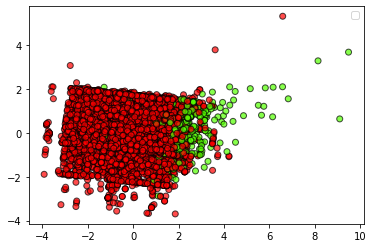

In [56]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_develop, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.legend()
plt.show()

In [57]:
# 3D PCA 
pca = PCA(n_components=3)
components = pca.fit_transform(X_develop[:,[0,2,3,6,7,9]])

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_develop,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

## Model selection: 
The parameters of the model are obtained after performing a stratified 10 fold cross validation through a coarse grid search


In [59]:
param_grid = {
               "max_depth": [3,4,5,6, None],
               "min_samples_leaf": [25,45,75,150,250,300],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 75}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 150}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 250}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 300}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 150}

Model with rank: 2
Mean va

Accuracy 0.9796902767199797
F1-score [0.98922704 0.82300885]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3710
           1       0.83      0.81      0.82       229

    accuracy                           0.98      3939
   macro avg       0.91      0.90      0.91      3939
weighted avg       0.98      0.98      0.98      3939



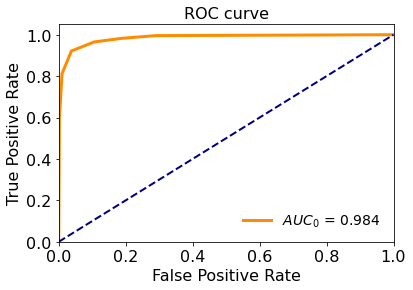

In [60]:
# unbalanced decision tree
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=3, min_samples_leaf= 25)
dtc.fit(X_develop[:,[0,2,3,6,7,9]],y_develop)

y_pred_dtc = dtc.predict(X_test[:,[0,2,3,6,7,9]])

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

y_score = dtc.predict_proba(X_test[:,[0,2,3,6,7,9]])
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

[[8571   94]
 [  88  437]]


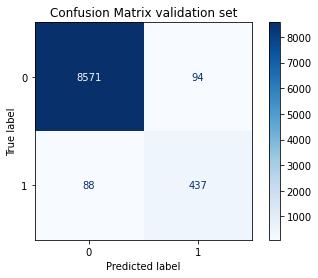

In [61]:
# confusion matrix
cm = plot_confusion_matrix(dtc,X_develop[:,[0,2,3,6,7,9]],y_develop,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix validation set')
print(cm.confusion_matrix)
plt.show()

# KNN - Unbalanced

In [62]:
# range of k to try - find a good range of k
k_range = range(1, 60)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_develop[:,[0,2,3,6,7,9]], y_develop, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 59/59 [01:41<00:00,  1.73s/it]


[0.9717083786724702, 0.9724700761697498, 0.9744287268770403, 0.9729053318824811, 0.9737758433079435, 0.9722524483133842, 0.9729053318824811, 0.9715995647442874, 0.9725788900979326, 0.9715995647442874, 0.9717083786724702, 0.9704026115342765, 0.9708378672470077, 0.9696409140369969, 0.9698585418933625, 0.9693144722524485, 0.9698585418933625, 0.9688792165397173, 0.9687704026115345, 0.9677910772578893, 0.967899891186072, 0.9672470076169752, 0.9674646354733408, 0.9665941240478781, 0.9668117519042438, 0.9664853101196954, 0.9662676822633299, 0.9655059847660501, 0.9657236126224159, 0.9659412404787814, 0.9658324265505988, 0.9651795429815018, 0.965614798694233, 0.9646354733405875, 0.9647442872687705, 0.964309031556039, 0.9644178454842219, 0.9639825897714906, 0.9640914036996733, 0.9633297062023939, 0.9638737758433077, 0.9632208922742109, 0.9634385201305765, 0.9630032644178452, 0.9633297062023939, 0.9626768226332969, 0.9632208922742109, 0.9624591947769312, 0.9628944504896626, 0.962568008705114, 0.9

Text(0, 0.5, 'Cross-validated accuracy')

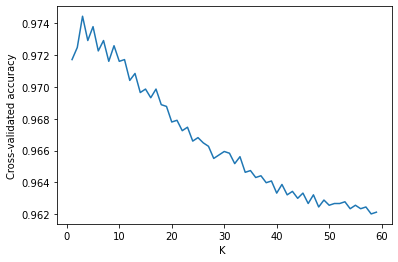

In [63]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

In [64]:
# repeat cv 10 times and average the results - to reduce the variance of the estimate
rep_kval_scor= {'mean': 0, 'std':0}
for i in range(10):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k_scores.index(max(k_scores))+1)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    score = cross_val_score(knn, X_develop[:,[0,2,3,6,7,9]], y_develop, cv=10, scoring='accuracy', verbose=1)
    # append mean of scores for k neighbors to k_scores list
    rep_kval_scor['mean'] += score.mean()
    rep_kval_scor['std']+= score.std()

print(f"accuracy over 10 cv repeated 10 times:\n\
mean: {rep_kval_scor['mean']/10} std(+/-): {rep_kval_scor['std']/10}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

accuracy over 10 cv repeated 10 times:
mean: 0.9744287268770402 std(+/-): 0.0034150935422143985


# KNN with PCA

In [65]:
# range of k to try - find a good range of k
k_range = range(1, 60)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_pca, y_develop, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


[0.9376496191512513, 0.9491838955386289, 0.9441784548422196, 0.948531011969532, 0.9454842219804135, 0.9505984766050053, 0.9510337323177366, 0.9500544069640913, 0.9497279651795429, 0.9489662676822632, 0.9480957562568009, 0.9495103373231772, 0.9495103373231772, 0.9499455930359085, 0.950816104461371, 0.951904243743199, 0.9517954298150162, 0.951904243743199, 0.9514689880304678, 0.9512513601741022, 0.9498367791077257, 0.9499455930359085, 0.9500544069640913, 0.9505984766050053, 0.950272034820457, 0.9510337323177366, 0.9507072905331881, 0.9504896626768226, 0.9498367791077257, 0.950272034820457, 0.9501632208922741, 0.950272034820457, 0.950272034820457, 0.950816104461371, 0.9509249183895537, 0.9510337323177366, 0.9515778019586506, 0.951360174102285, 0.9516866158868333, 0.951360174102285, 0.9510337323177366, 0.9512513601741022, 0.951360174102285, 0.9512513601741022, 0.951360174102285, 0.9511425462459193, 0.950816104461371, 0.9507072905331881, 0.9510337323177366, 0.9509249183895537, 0.95081610446

## Predict with KNN

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3710
           1       0.83      0.69      0.75       229

    accuracy                           0.97      3939
   macro avg       0.90      0.84      0.87      3939
weighted avg       0.97      0.97      0.97      3939

legend:
0: not popular
1: popular


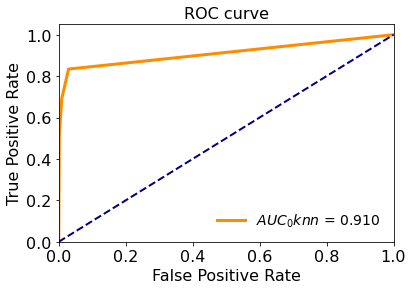

In [66]:
knn_classifier = KNeighborsClassifier(n_neighbors = 3)

# retrain knn on the whole development set
knn_classifier.fit(X_develop[:,[0,2,3,6,7,9]], y_develop)
# predict target variable
y_pred_knn = knn_classifier.predict(X_test[:,[0,2,3,6,7,9]])
# display classification report
print(classification_report(y_test, y_pred_knn))
print('legend:\n0: not popular\n1: popular')

# plot ROC curve -KNN
y_scoreknn = knn_classifier.predict_proba(X_test[:,[0,2,3,6,7,9]])
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scoreknn[:, 1])
roc_auc1 = auc(fpr_knn, tpr_knn)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_0knn$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## ROC curve Decision tree - KNN

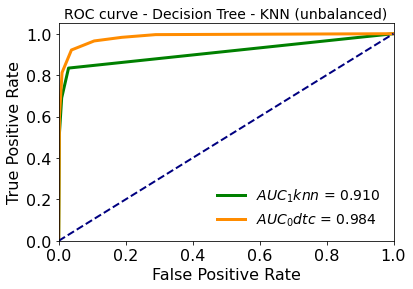

In [70]:
plt.plot(fpr_knn, tpr_knn, color='green', lw=3, label='$AUC_1knn$ = %.3f' % roc_auc1)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0dtc$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - Decision Tree - KNN (unbalanced)', fontsize=14)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()